# Application Example for EvoBandits

Setup

In [1]:
import json
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from matplotlib.ticker import LogLocator, LogFormatter
import numpy as np
from tqdm import tqdm

In [2]:
from application_example import (
    genetic_algorithm,
    TSP_CITIES,
    TSP_OPT_COST,
    TSP_OPT_TOUR
)

In [3]:
plt.style.use("default")

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = [
    "Computer Modern Roman",
    "Times New Roman",
    "Times",
    "DejaVu Serif",
]
mpl.rcParams["font.size"] = 16


## 1. Application Example

A genetic algorithm, which solves a fixed instance of the Traveling Salesman Problem (TSP), is applied as example for a stochastic optimization problem. 

The known optimal tour of this 100-city TSP can be used as reference for the evaluation of optimization results.

In [4]:
print(f"Cost of the best tour:\t{TSP_OPT_COST}")

Cost of the best tour:	7.28473


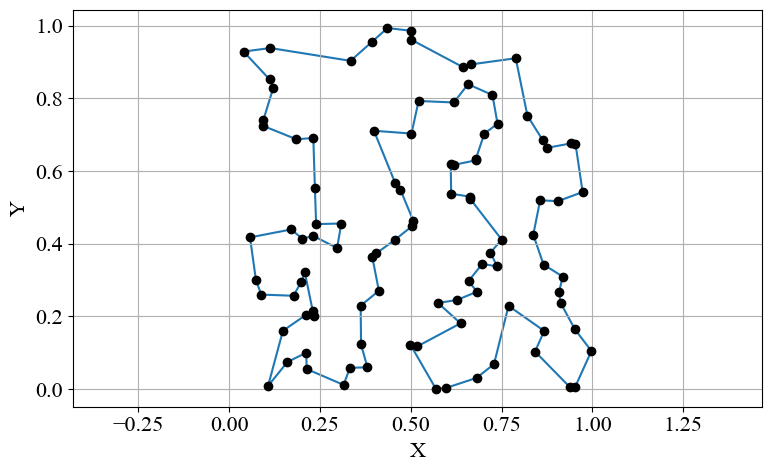

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

tour_path = TSP_CITIES[TSP_OPT_TOUR]
tour_path = np.vstack([tour_path, tour_path[0]])
ax.plot(tour_path[:, 0], tour_path[:, 1], "-", c="C0", zorder=1)
ax.scatter(TSP_CITIES[:, 0], TSP_CITIES[:, 1], c="black", zorder=2)

ax.grid(True)
ax.axis("equal")
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.tight_layout()
plt.savefig(Path("_plots/01_tsp_opt.pdf"))
plt.show()

## 2. Optimization with EvoBandits

### 2.1 Optimization

The configuration of the genetic algorithm will be optimized using EvoBandits.

Objective Function:

In [6]:
def objective(seed: int, **params: dict):
    """Seeded, single-objective function to simulate the GA."""
    best_cost, _ = genetic_algorithm(seed=seed, **params)
    return best_cost

Parameter Space for the optimization:

In [7]:
from evobandits import IntParam, CategoricalParam, FloatParam

params = {
    "pop_size": IntParam(low=50, high=250, size=1),
    "generations": CategoricalParam(choices=[100, 200, 300, 400, 500]),
    "elite_split": FloatParam(low=0.0, high=0.2, n_steps=20), 
    "tournament_split": FloatParam(low=0.0, high=0.1, n_steps=10),
    "mutation_rate": FloatParam(low=0.0, high=1.0, n_steps=100), 
    "crossover_rate": FloatParam(low=0.0, high=1.0, n_steps=100), 
}

Algorithm Configuration:

In [8]:
from evobandits import GMAB

gmab_instance = GMAB(population_size=10)

The optimization requires wrapping the genetic algorithm, so that only the objective value (best_cost) is returned as single objective for the optimizer:

In [9]:
from evobandits import Study

study = Study(algorithm=gmab_instance, seed=42)
study.optimize(objective, params, n_trials=1000)

In [10]:
json.dump(study.results, open(Path("_data/evobandits_demo_01_results.json"), 'w'))

### 2.2 Study Output

Display results (example):

In [11]:
print(f"Configuration with best result:\t{study.best_params}")
print(f"Best cost found with evobandits:\t{study.best_value}")
print(f"Number of evaluations:\t{study.best_solution["n_evaluations"]}")
print(f"Std. deviation:\t{study.best_solution["value_std_dev"]}")

Configuration with best result:	{'pop_size': 226, 'generations': 500, 'elite_split': 0.04, 'tournament_split': 0.05, 'mutation_rate': 0.78, 'crossover_rate': 0.0}
Best cost found with evobandits:	7.925576596461831
Number of evaluations:	23
Std. deviation:	0.2267098132417647


# 3. Analysis of the best result

Re-evaluate best configuration, and compare to the best reported value from optimization.

In [12]:
results = []
rng = np.random.default_rng(seed=42)

for _ in tqdm(range(1000), desc="Re-evaluate best configuration:"):
    seed = rng.integers(0, 2**32 - 1, dtype=int)
    best_cost, _ = genetic_algorithm(seed=seed, **study.best_params)
    results.append(best_cost)

json.dump(results, open(Path("_data/evobandits_demo_02_evaluation.json"), 'w'))

Re-evaluate best configuration:: 100%|██████████| 1000/1000 [38:21<00:00,  2.30s/it]


In [13]:
print(f"Mean result:\t{np.mean(results)}")
print(f"Std. deviation:\t{np.std(results)}")
print(f"Min value:\t{np.min(results)}")
print(f"Max value:\t{np.max(results)}")
print(f"Median value:\t{np.median(results)}")

Mean result:	8.002039591046593
Std. deviation:	0.24788827635849456
Min value:	7.394178067227115
Max value:	8.869300220593225
Median value:	7.989829096059299


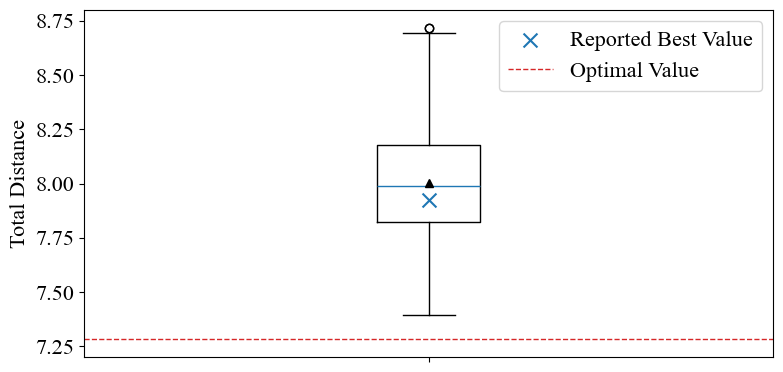

In [14]:
plt.figure(figsize=(8, 4))

plt.boxplot(results, tick_labels=[""], showmeans=True, meanprops={"markerfacecolor":"black", "markeredgecolor":"black"}, medianprops={"color": "C0"})
plt.scatter(1, study.best_value, marker='x', s=100, color="C0", label="Reported Best Value")
plt.axhline(TSP_OPT_COST, linestyle='--', linewidth=1, color="C3", label="Optimal Value")

plt.ylabel("Total Distance")
plt.ylim(7.20, 8.80)

plt.legend()
plt.tight_layout()
plt.savefig(Path("_plots/02_evobandits_demo_results.pdf"))
plt.show()

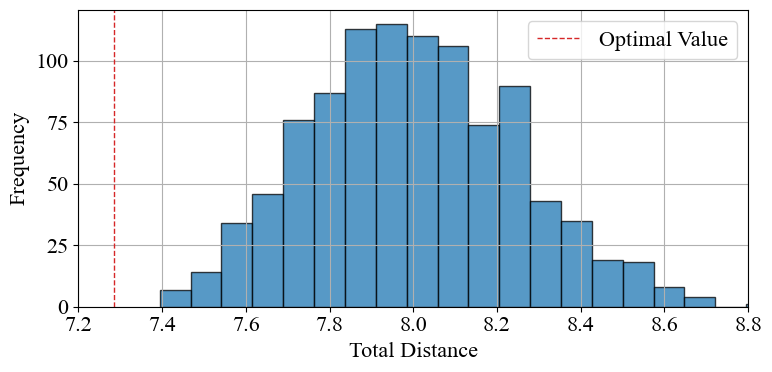

In [15]:
plt.figure(figsize=(8, 4))
plt.grid()

plt.hist(results, bins=20, alpha=0.75, edgecolor="black")
plt.axvline(TSP_OPT_COST, linestyle='--', linewidth=1, color="C3", label="Optimal Value")

plt.xlabel("Total Distance")
plt.ylabel("Frequency")
plt.xlim(7.20, 8.80)
plt.legend()

plt.tight_layout()
plt.savefig(Path("_plots/03_ga_results_spread.pdf"))
plt.show()

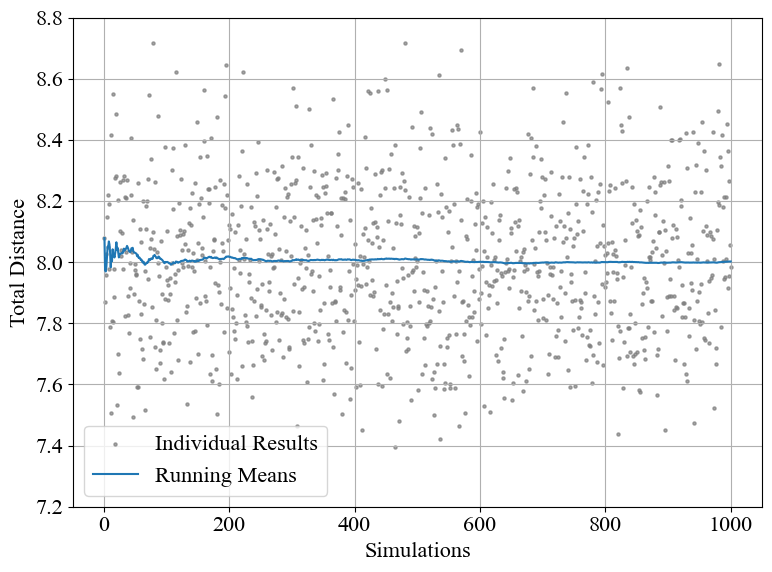

In [16]:
plt.figure(figsize=(8, 6))
plt.grid()

sim_idx = np.arange(1, len(results) + 1)
plt.scatter(sim_idx, results, s=5, alpha=0.7, color="C7", label="Individual Results")

running_means = np.cumsum(results) / sim_idx
plt.plot(sim_idx, running_means, color="C0", label="Running Means")

plt.ylabel("Total Distance")
plt.xlabel("Simulations")
plt.ylim(7.20, 8.80)
plt.legend()

plt.tight_layout()
plt.savefig(Path("_plots/03_ga_results_means.pdf"))
plt.show()

# 4. Extras - Visualization of the Hyperspace

Simulation from above is repeated - all results are stored for visualization, not just the best one*

*as of EvoBandits version 0.0.6, ucb ranking was not yet applied after optimization to accurately rank results.

In [17]:
# Load best result from (3) as reference result.
with open("_data/evobandits_demo_01_results.json", "r") as f:
    reference_result = json.load(f)[0]

In [18]:
# Re-Run the Study and collect all results

study = Study(algorithm=gmab_instance, seed=42)
study.optimize(objective, params, n_trials=1000, n_best=1000)

In [19]:
print("Number of unique solutions (arms):", len(study.results))

Number of unique solutions (arms): 465


In [20]:
json.dump(study.results, open(Path("_data/evobandits_demo_01_all_arms.json"), 'w'))

### 4.1 Plots

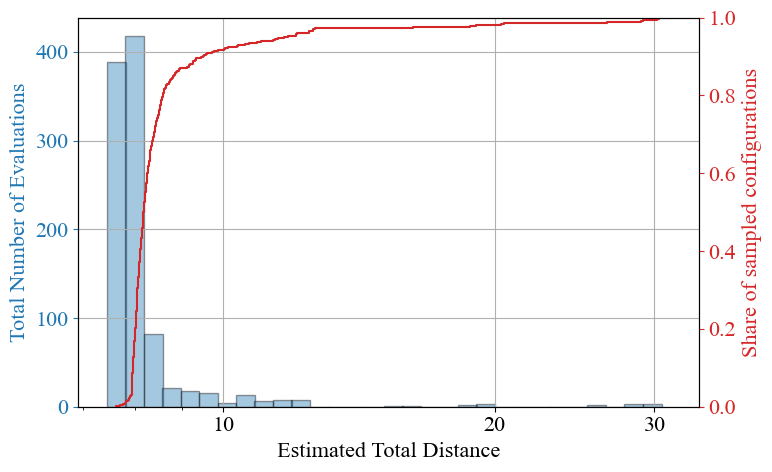

In [22]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# --- Plot ECDF of values ---
values = np.array([r["value"] for r in study.results])
ax2_col = "C3"

ax2 = ax1.twinx()
ax2.ecdf(values, color=ax2_col)
ax2.set_ylabel('Share of sampled configurations', color=ax2_col)
ax2.tick_params(axis='y', colors=ax2_col)

# --- Bin total n_evaluations per value
n_evaluations = np.array([r["n_evaluations"] for r in study.results])
n_bins = 30

bins = np.logspace(np.log10(values.min()), np.log10(values.max()), n_bins + 1)
bin_indices = np.digitize(values, bins) - 1
n_eval_per_bin = np.zeros(n_bins)

for i in range(n_bins):
    n_eval_per_bin[i] = n_evaluations[bin_indices == i].sum()

# ---- Plot n_evaluations per value ---
ax1_col = "C0"
bin_lefts = bins[:-1]
bin_widths = np.diff(bins)
ax1.bar(bin_lefts, n_eval_per_bin, width=bin_widths, color=ax1_col, alpha=0.4, edgecolor='k')

ax1.set_ylabel("Total Number of Evaluations", color=ax1_col)
ax1.tick_params(axis='y', colors=ax1_col)

# Logscale X-Axis, including tick labels
ax1.set_xlabel("Estimated Total Distance")
ax1.set_xscale("log")
ax1.xaxis.set_major_locator(LogLocator(base=10.0, subs=(5, 10, 20, 30)))
ax1.xaxis.set_major_formatter(LogFormatter(base=10.0, labelOnlyBase=False))
ax1.grid()

plt.tight_layout()
plt.savefig(Path("_plots/04_ecdf_values.pdf"))
plt.show()

In [27]:
def plot_heatmap(ax, x_feature, y_feature, bins, cmap_gamma=1, results=study.results, show_best=None):
    # Extract data
    x = np.array([r["params"][x_feature] for r in results])
    y = np.array([r["params"][y_feature] for r in results])
    heat = np.array([r["value"] for r in results])

    # Define grid
    x_bins = np.linspace(min(x), max(x), bins[0])
    y_bins = np.linspace(min(y), max(y), bins[1])

    # Bin data into 2D histogram: average "value" per bin
    heatmap = np.full((len(x_bins) - 1, len(y_bins) - 1), np.nan)
    counts = np.zeros_like(heatmap)

    # Bin manually to compute mean per bin
    digitized_x = np.digitize(x, x_bins) - 1
    digitized_y = np.digitize(y, y_bins) - 1

    for xi, yi, val in zip(digitized_x, digitized_y, heat):
        if 0 <= xi < heatmap.shape[0] and 0 <= yi < heatmap.shape[1]:
            if np.isnan(heatmap[xi, yi]):
                heatmap[xi, yi] = val
                counts[xi, yi] = 1
            else:
                heatmap[xi, yi] += val
                counts[xi, yi] += 1

    # Avoid divide-by-zero
    heatmap = heatmap / np.where(counts == 0, 1, counts)
    heatmap[counts == 0] = np.nan  # reset truly empty bins

    # Plot on given axis
    norm = PowerNorm(gamma=cmap_gamma)
    mesh = ax.pcolormesh(x_bins, y_bins, heatmap.T, cmap='Blues_r', norm=norm)
    
    # Add colorbar? 
    # Usually colorbar should be added outside for subplots, but optional here:
    # fig = ax.figure
    # fig.colorbar(mesh, ax=ax, label='Mean total distance')

    if show_best:
        ax.scatter(show_best[0], show_best[1], color="C3", marker="x", s=100, label="Best")
        # ax.text(best_x + 0.01, best_y + 0.01, f"{best_value:.2f}", color="C3", weight="bold", fontsize=16)
        ax.legend()

    ax.set_xlim((min(x), max(x)))
    ax.set_ylim((min(y), max(y)))
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)

    return mesh

In [36]:
def plot_violin(ax, feature, tick_labels=None, results=study.results, show_best=None):
    # Extract data
    features = np.array([r["params"][feature] for r in results])
    values = np.array([r["value"] for r in results])

    # Group data by unique feature values
    unique_features = np.sort(np.unique(features))
    grouped_values = [values[features == feature_value] for feature_value in unique_features]

    # Plot violin plot
    positions = range(1, len(unique_features) + 1)
    ax.violinplot(grouped_values, positions=positions, showextrema=True, showmedians=True)
    ax.set_xticks(positions)

    if not tick_labels:
        tick_labels = [f"{val:.2f}" for val in unique_features]
    ax.set_xticklabels(tick_labels)

    # Counts above violins
    y_max = max(values)
    y_min = min(values)
    y_range = y_max - y_min
    for i, g in enumerate(grouped_values, 1):
        ax.text(i, max(g) + 0.05 * y_range, f"{len(g)}", ha='center', va='bottom')

    # Highlight best
    if show_best:
        pos = list(unique_features).index(show_best[0]) + 1  # positions start at 1
        ax.scatter(pos, show_best[1], color='C3', marker='x', s=100, label='Best')
        # ax.text(pos + 0.05, best_value - 0.05 * y_range, f"{best_value:.2f}", color='C3', fontsize=16, weight='bold')

    ax.set_xlabel(feature)
    
    # Logscale X-Axis, including tick labels
    ax.set_ylabel("Estimated Total distance")
    ax.set_ylim(top=y_max * 1.2)
    ax.set_yscale("log")
    ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=(5, 10, 20, 30)))
    ax.yaxis.set_major_formatter(LogFormatter(base=10.0, labelOnlyBase=False))

    return ax

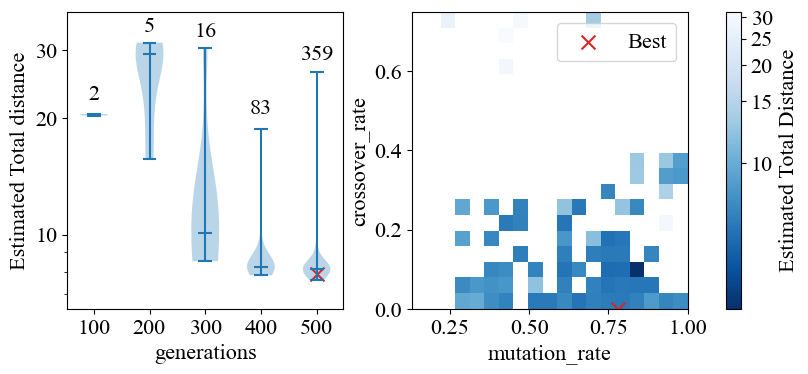

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

mesh1 = plot_heatmap(axs[1], "mutation_rate", "crossover_rate", bins=(20, 20), cmap_gamma=0.3, show_best=(reference_result["params"]["mutation_rate"], reference_result["params"]["crossover_rate"]))
plot_violin(axs[0], "generations", tick_labels=["100", "200", "300", "400", "500"], show_best=(reference_result["params"]["generations"], reference_result["value"]))

# Adjust spacing between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

# Shared colorbar for both plots:
cbar = fig.colorbar(mesh1, ax=axs, orientation='vertical', label='Estimated Total Distance')

plt.savefig(Path("_plots/05_hyperspace_projections.pdf"))
plt.show()